<a href="https://colab.research.google.com/github/jay10440/full-statistical-projects/blob/main/Temperature_Weather_Analysis_in_Seattle_via_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Taken from Seattle's Weather Station, KBFI, I was interested to see how well a simple differenced ARIMA model would forecast the temperatures of some months of summer using just the month of June.

The data was collected from visualcrossing.com in the form of a csv file. Throughout this notebook, we first start by cleaning the data, separating just the temperature and times needed for the observations, and then we proceed with checking for stationarity, constructing the model, using it to create the forecast and comparing it with the historical data we obtained from the API.

##Packages

There are a number of packages I want to use to analyze this data. First, I just have to have pacman, it's so nice in loading the packages in. I have patchwork just in case, I thought I might needed it to append the graphs, but my big things for sure are forecast, ggplot2, zoo, lubridate (possibly), hrbrthemes (for nice colored graphs and shades), etc. I also used some basic time series tools to just compare with things I'm seeing in zoo.

In [1]:
install.packages(c("dplyr","ggplot2","readr","pacman"))
install.packages("patchwork")
install.packages("forecast")
install.packages("tidyverse")
install.packages("TSStudio")
install.packages("prophet")
install.packages("TSeries")
install.packages("zoo")
install.packages("xts")
install.packages("lubridate")
install.packages("plotly")
library(plotly)
install.packages("hrbrthemes")
library(hrbrthemes)
pacman::p_load(forecast,tidyverse,TSStudio,prophet,TSeries,zoo,xts,lubridate,ggplot2,data.table)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘TSStudio’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“Perhaps you meant ‘TSstudio’ ?”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies 

##Reading in and Cleaning the Data
First, I'll bring it in as a csv. Check the data, then I need to gather the dates and temperatures, make a data frame out of it and we'll take a look at what it looks like with ggplot.

In [2]:
data<- read.csv('seattle 2025-06-01 to 2025-07-01.csv')

In [3]:
#Checking to see what it looks like
head(data)

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,⋯,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
1,seattle,2025-06-01T00:00:00,53.1,53.1,43.9,70.90,0,0,,0,⋯,1025.3,88.8,9.9,0,0,0,10,Partially cloudy,partly-cloudy-night,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"
2,seattle,2025-06-01T01:00:00,52.7,52.7,43.9,71.96,0,0,,0,⋯,1025.6,88.8,9.9,0,0,0,10,Partially cloudy,partly-cloudy-night,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"
3,seattle,2025-06-01T02:00:00,53.0,53.0,44.9,73.97,0,0,,0,⋯,1025.6,87.0,9.9,0,0,0,10,Partially cloudy,partly-cloudy-night,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"
4,seattle,2025-06-01T03:00:00,53.0,53.0,45.2,74.85,0,0,,0,⋯,1025.6,90.7,9.9,0,0,0,10,Overcast,cloudy,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"
5,seattle,2025-06-01T04:00:00,51.2,51.2,46.0,82.23,0,0,,0,⋯,1025.9,50.1,9.9,0,0,0,10,Partially cloudy,partly-cloudy-night,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"
6,seattle,2025-06-01T05:00:00,49.7,49.7,45.4,85.12,0,0,,0,⋯,1026.3,4.1,9.9,0,0,0,10,Clear,clear-night,"72793024233,KSEA,KBFI,72793524234,72793494248,F0821,KRNT"


In [5]:
times<- data$datetime
timesct<- as.POSIXct(times)
#Taking the times out and putting it in the right format for the time series.

In [6]:
#Gonna run with the zoos package here to generate the time series.
temps<-zoo(data$temp, order.by=timesct)
temps_df <- fortify.zoo(temps) #GGplot needs a data frame and I can make one
#directly by using the fortify.zoo operation.
names(temps_df)<- c("date","temperature")
str(temps_df)
temps_df

Warning message in zoo(data$temp, order.by = timesct):
“some methods for “zoo” objects do not work if the index entries in ‘order.by’ are not unique”


'data.frame':	744 obs. of  2 variables:
 $ date       : POSIXct, format: "2025-06-01" "2025-06-01" ...
 $ temperature: num  53.1 52.7 53 53 51.2 49.7 49.9 51.5 53.7 55.8 ...


date,temperature
<dttm>,<dbl>
2025-06-01,53.1
2025-06-01,52.7
2025-06-01,53.0
2025-06-01,53.0
2025-06-01,51.2
2025-06-01,49.7
2025-06-01,49.9
2025-06-01,51.5
2025-06-01,53.7


NULL

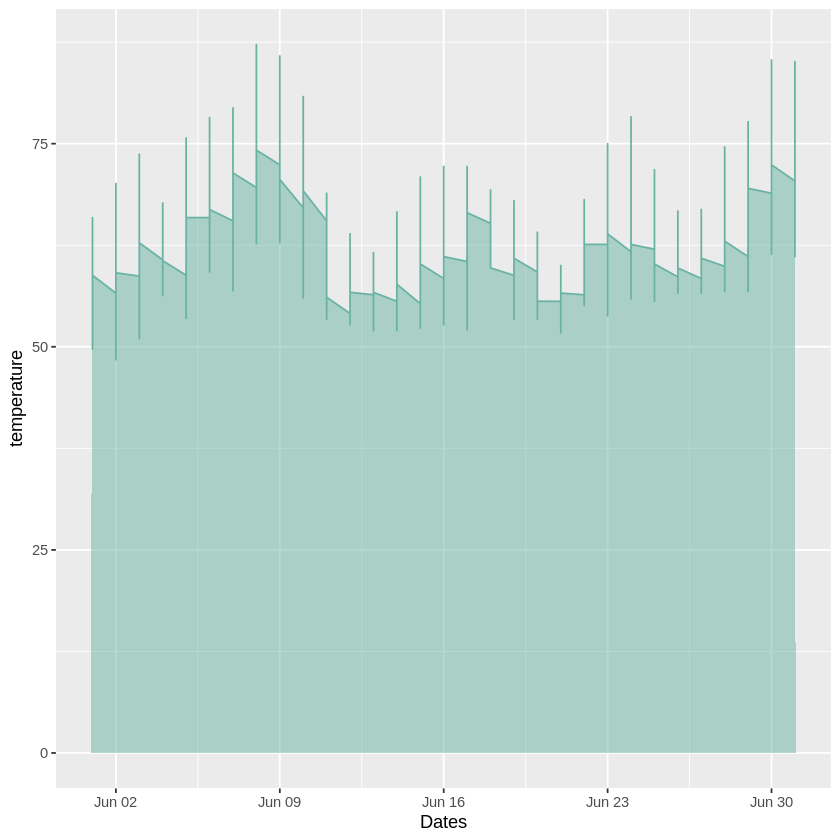

[1] 713

Time differences in secs
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0    3489       0   86400 

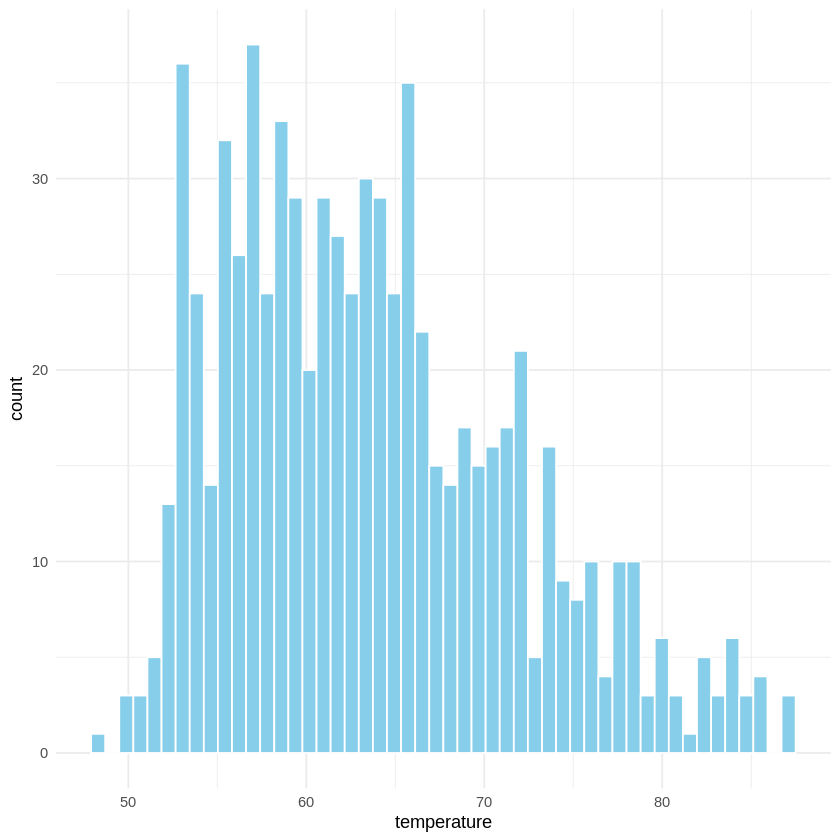

In [7]:
fanciertemps <- temps_df %>%
  ggplot( aes(x=date, y=temperature)) +
    geom_area(fill="#69b3a2", alpha=0.5) +
    geom_line(color="#69b3a2") +
    xlab("Dates")
    ylab("temperature") +
    theme_ipsum()
fanciertemps
#Fancy Graph from ggplot2 I found online, looks nice!
#Big problem though. There's spikes, this is likely repeated observations
#from the way the csv was gathered so we'll take a look at a few things
#to see how we can fix this.
ggplot(temps_df, aes(x = temperature)) +
  geom_histogram(bins = 50, fill = "skyblue", color = "white") +
  theme_minimal()
sum(duplicated(temps_df$date))
summary(diff(temps_df$date))

With a little bit of assistance, we determined that there might be repeated observations which could mess up our ARIMA model when we make it. We'll get rid of the observations using a few pipelines for some date cleaning and attempt to make it hourly (which is what it was supposed to be from the way we read it in):

[1] 0

NULL

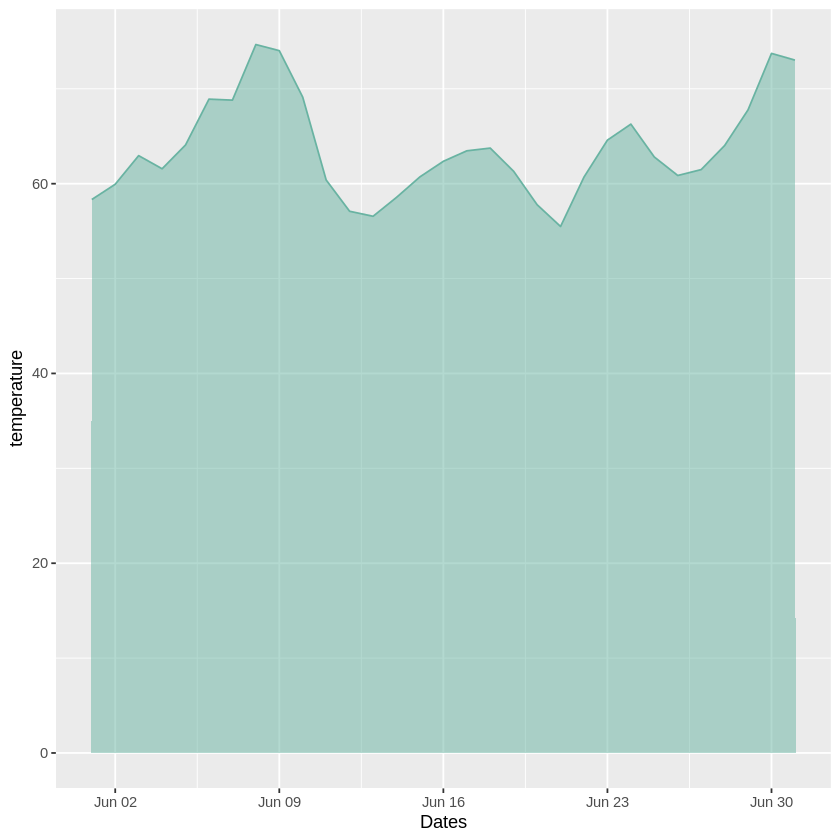

In [8]:
#Cleaning up the data
temps_df_clean<- temps_df %>% group_by(date) %>% summarise(temperature = mean(temperature, na.rm=TRUE),.groups="drop")
sum(duplicated(temps_df_clean$date))
#Making it hourly:
temps_df_clean<- temps_df_clean %>%
  mutate(rounded_date=lubridate::round_date(date,unit="hour")) %>%
  group_by(rounded_date) %>%
  summarise(temperature = mean(temperature),.groups="drop")

#Rechecking the plot:
cleanfanciertemps <- temps_df_clean %>%
  ggplot( aes(x=rounded_date, y=temperature)) +
    geom_area(fill="#69b3a2", alpha=0.5) +
    geom_line(color="#69b3a2") +
    xlab("Dates")
    ylab("temperature") +
    theme_ipsum()
cleanfanciertemps

I didn't get the data hourly (I may find a cleaner way to do that on another round of analysis sometime down the road), but I'm OK with this for now.

## Creating the Time Series, ACF, PACF and ARIMA model
I'll use the `str()` command to get an idea of what the data looks like. But from there, I'm ready to use the `zoo()` command to create our time series. From our data frame, we'll use the temperature and date columns as we constructed them before.

In [9]:
str(temps_df_clean)
fixedtemps<- zoo(temps_df_clean$temperature, order.by = temps_df_clean$rounded_date)
str(fixedtemps)

tibble [31 × 2] (S3: tbl_df/tbl/data.frame)
 $ rounded_date: POSIXct[1:31], format: "2025-06-01" "2025-06-02" ...
 $ temperature : num [1:31] 58.3 59.9 63 61.6 64.1 ...
‘zoo’ series from 2025-06-01 to 2025-07-01
  Data: num [1:31] 58.3 59.9 63 61.6 64.1 ...
  Index:  POSIXct[1:31], format: "2025-06-01" "2025-06-02" "2025-06-03" "2025-06-04" "2025-06-05" ...


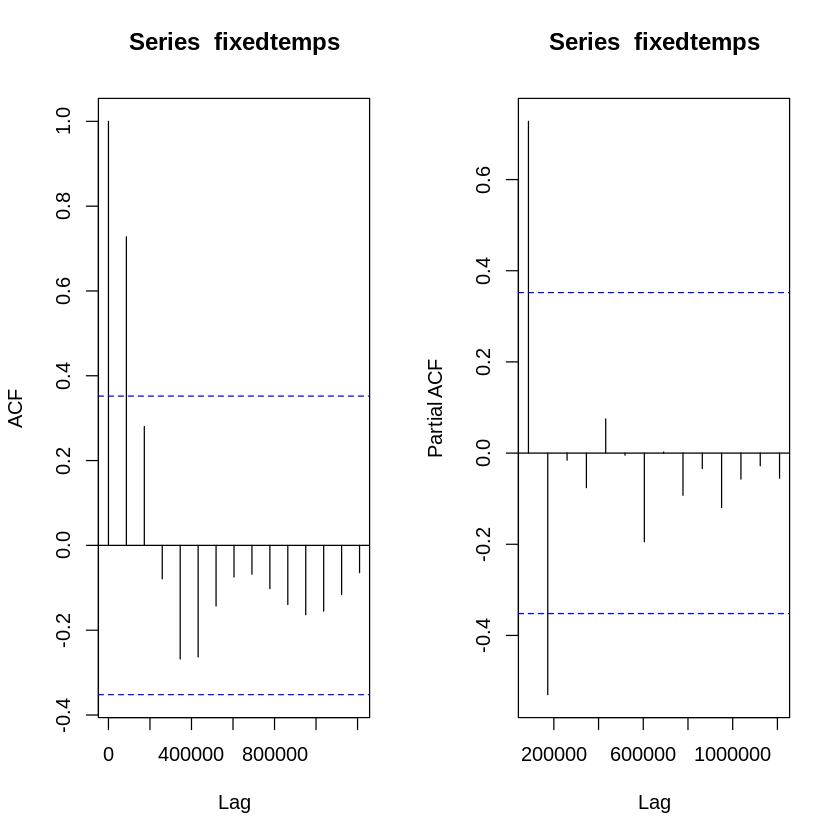

In [10]:
par(mfrow=c(1,2))
acf(fixedtemps)
pacf(fixedtemps)

The ACF is generally used for moving average models (MA) and the Partial ACF is generally used for autoregressive models (AR). Since the ARIMA is a combination of both of those, it's good to check both to make sure there's no craziness in the stationarity. We cna see that the lag dies down on both pretty quickly so this is nice. We're ready to construct our ARIMA model!

Series: fixedtemps 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     mean
      1.2730  -0.6407  63.5796
s.e.  0.1353   0.1419   1.2398

sigma^2 = 7.091:  log likelihood = -73.76
AIC=155.52   AICc=157.06   BIC=161.26

           Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
1751414400       69.09560 65.68294 72.50825 63.87639 74.31480
1751500800       64.55249 59.02798 70.07700 56.10349 73.00150
1751587200       61.28394 54.82617 67.74170 51.40764 71.16024
1751673600       60.03381 53.41007 66.65756 49.90367 70.16396
1751760000       60.53658 53.90747 67.16570 50.39823 70.67494
1751846400       61.97760 55.22534 68.72986 51.65091 72.30428
1751932800       63.48992 56.58094 70.39891 52.92354 74.05631
1752019200       64.49188 57.50501 71.47875 53.80639 75.17737
1752105600       64.79843 57.80086 71.79599 54.09657 75.50028
1752192000       64.54670 57.54697 71.54643 53.84153 75.25187
1752278400       64.02984 57.01438 71.04530 53.30062 74.75906
1752364800       63.53314 56.50086 70.56542 52.77819 74.28809
1752451200       63.23199 56.19252 70.27146 52.46605 73.99793
1752537600       63.16686 56.12677 70.20695 52.39997 73.93375
1752624000       63.27690 56.23630 70.31750 52.50923 74.04457
17527104

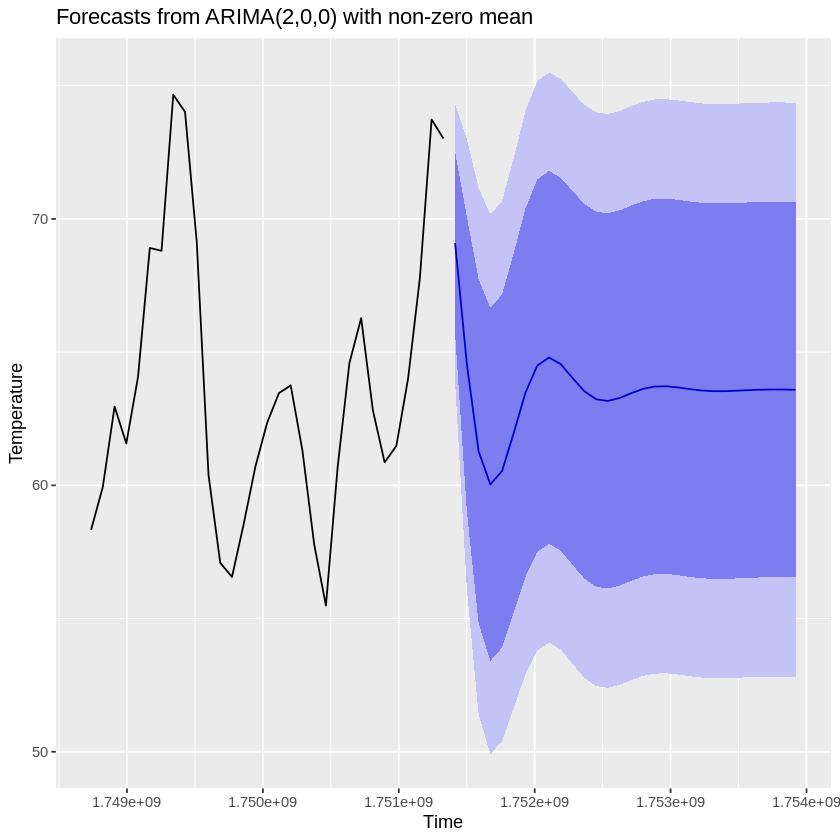

In [11]:
#OK, let's forecast!
#Wait, so I just learned that the auto.arima will difference for me, oh boy...
arimatemps<- auto.arima(fixedtemps)
arimatemps
futuretemps<-forecast(arimatemps, h=30)
#I decided to take this out for another 30 days.
futuretemps
autoplot(futuretemps, xlab="Time", ylab="Temperature")

We don't have any moving average parts and this data wasn't differenced, so we have an ARIMA(2,0,0), represented as:
$$x_t =\mu + \phi_1 x_{t-1} + \phi_2 x_{t-2} + w_t$$
For our coefficients, we had Coefficients:
         ar1      ar2     mean
      1.2730  -0.6407  63.5796

  $$x_t = 63.5796 + 1.2730 x_{t-1} - .6407 x_{t-2}$$

We then use this model to build a forecast and the forecast along with the confidence intervals of 80% and 95% are shown in the graph above.

##Visualization

I'm technically done with the analysis, we could do a bit more, and there's a lot to explore with this data, trend analysis, adding in noise, multivariate time series, etc. But for now, I want to be picky about my visuals so this is easy to read.

I"ll start first by taking my time values (they're all in seconds from the year 1970-01-01), convert them over and turn them back into dates in GMT like we had it.

I'll then create a dataframe with our forecasted temps, just those alone.

Lastly, I'll combine the dataframes together and plot them on the graph so we can compare the historical temperature of June 2025 with the projected temperatures of July.

In [242]:
#OK, now to get it off this ugly time.
times_number<-as.numeric(time(futuretemps$mean))
forecast_datetime<- as.POSIXct(times_number, origin="1970-01-01", tz="GMT")
forecast_datetime

 [1] "2025-07-02 GMT" "2025-07-03 GMT" "2025-07-04 GMT" "2025-07-05 GMT"
 [5] "2025-07-06 GMT" "2025-07-07 GMT" "2025-07-08 GMT" "2025-07-09 GMT"
 [9] "2025-07-10 GMT" "2025-07-11 GMT" "2025-07-12 GMT" "2025-07-13 GMT"
[13] "2025-07-14 GMT" "2025-07-15 GMT" "2025-07-16 GMT" "2025-07-17 GMT"
[17] "2025-07-18 GMT" "2025-07-19 GMT" "2025-07-20 GMT" "2025-07-21 GMT"
[21] "2025-07-22 GMT" "2025-07-23 GMT" "2025-07-24 GMT" "2025-07-25 GMT"
[25] "2025-07-26 GMT" "2025-07-27 GMT" "2025-07-28 GMT" "2025-07-29 GMT"
[29] "2025-07-30 GMT" "2025-07-31 GMT"

In [243]:
#Making a data frame and running the plot:
forecast_df <- data.frame(
  datetime = forecast_datetime,
  forecast = as.numeric(futuretemps$mean),
  lower80 = as.numeric(futuretemps$lower[, "80%"]),
  upper80 = as.numeric(futuretemps$upper[, "80%"]),
  lower95 = as.numeric(futuretemps$lower[, "95%"]),
  upper95 = as.numeric(futuretemps$upper[, "95%"])
)
#forecast_df

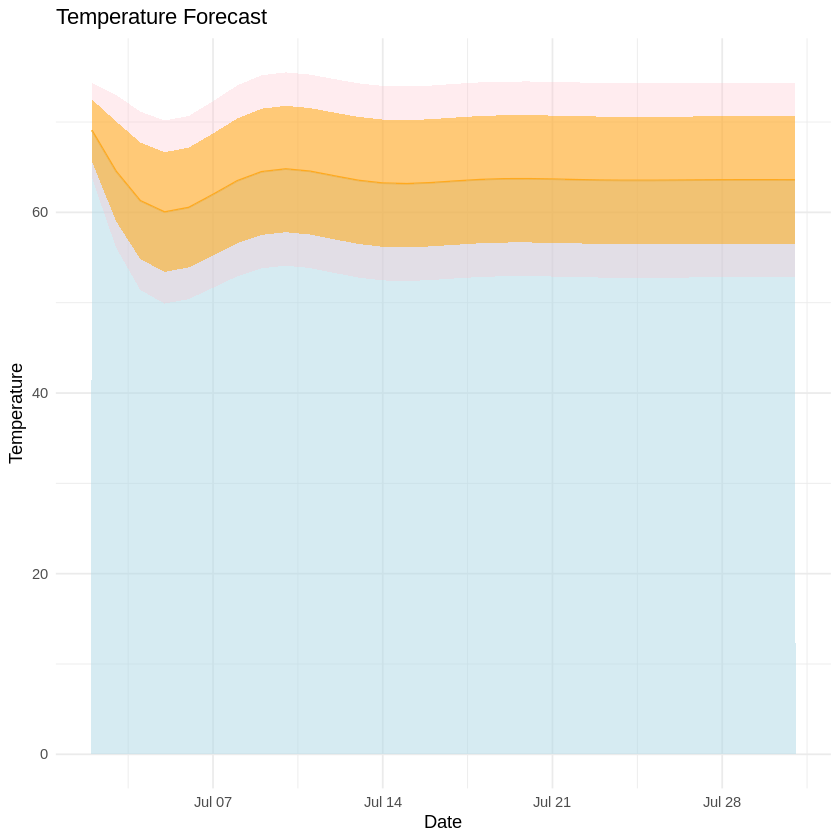

In [244]:
#Here's a plot of the projected temperatures. It wasn't really necessary to keep
#the bands but weather is ridiculously unstable sometimes. Get ready for the
#heat!
projectedforecast<-
  ggplot(forecast_df, aes(x = datetime, y = forecast)) +
  geom_line(color = "orange") +                 # Forecast line
  geom_area(fill="#ADD8E6", alpha=0.5) +
  geom_ribbon(aes(ymin = lower95, ymax = upper95), fill = "pink", alpha = 0.3) +  # 95% CI
  geom_ribbon(aes(ymin = lower80, ymax = upper80), fill = "orange", alpha = 0.5) +    # 80% CI
  labs(title = "Temperature Forecast", x = "Date", y = "Temperature") +
  theme_minimal()

projectedforecast

In [245]:
#Combining the two dataframes:
# Make sure datetime formats match
temps_df_clean <- temps_df_clean %>%
  mutate(source = "observed") %>%
  rename(datetime = rounded_date,
         value = temperature)

forecast_df <- forecast_df %>%
  mutate(source = "forecast") %>%
  rename(value = forecast)

# Combine the two
combined_df <- bind_rows(temps_df_clean, forecast_df)

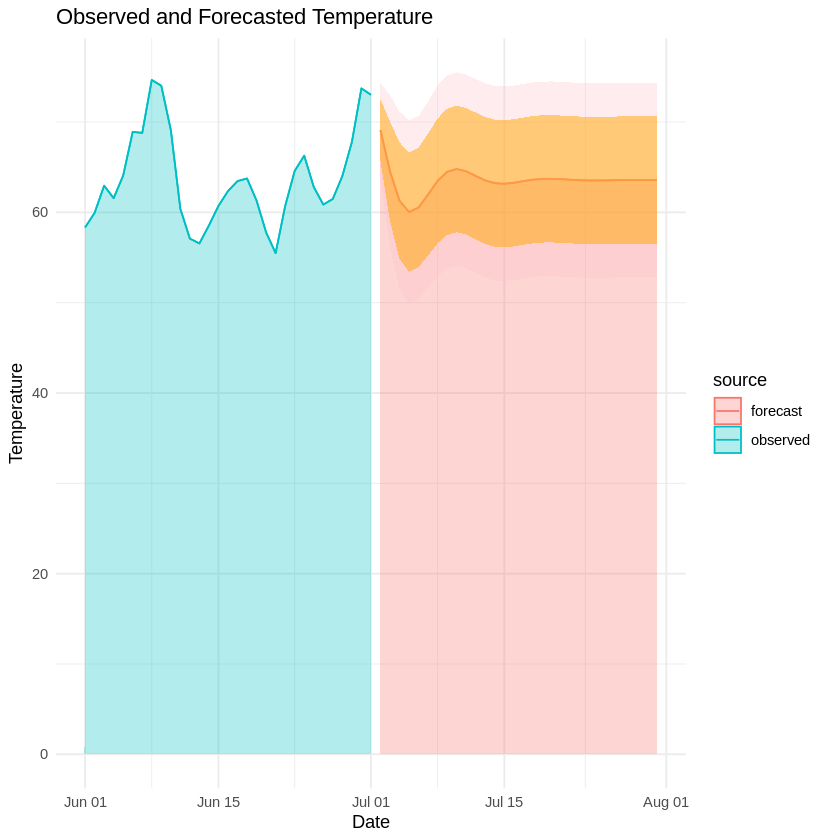

In [246]:
ggplot(combined_df, aes(x = datetime, y = value, color = source, fill = source)) +
  geom_line() +
  geom_area(alpha = 0.3, position = "identity") +

  # 95% Confidence Ribbon
  geom_ribbon(data = filter(combined_df, source == "forecast"),
              aes(x = datetime, ymin = lower95, ymax = upper95),
              inherit.aes = FALSE,
              fill = "pink", alpha = 0.3) +

  # 80% Confidence Ribbon
  geom_ribbon(data = filter(combined_df, source == "forecast"),
              aes(x = datetime, ymin = lower80, ymax = upper80),
              inherit.aes = FALSE,
              fill = "orange", alpha = 0.5) +

  labs(title = "Observed and Forecasted Temperature",
       x = "Date", y = "Temperature") +
  theme_minimal()

For basic ARIMA models, we do expect things to level out in our model if we're not including noise or shocks.

Naturally, temperature doesn't behave this way! It's dependent on many factors. One interesting thing we could try next is to see better how we can capture the seasonality of the data. Even in a daily observation, we note that the temperatures are sinusoidal in nature. We may be able to do this using some fourier tools and we'll see if we can construct a more accurate model using those tools.